# Simulation companion for HTE Models' Slides
Julian Hsu
12 june 2023

The purpose of this script is to generate simulation results to support conclusions and talking point of the `5 HTE Models 20230616 Update` slides. 

### Questions:
1. How does HTE performance change when there is no overlap in propensity score?
2. How does HTE performance change when there is overlap in propensity score, but one a feature that drive HTE? 


In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



## Functions that generate data and estimate HTE
Create a function that allows for no propensity overlap, and a different function that allows for propensity overlap but not overlap in some HTE variables.

In [2]:
def logit_hte(y=None,x=None,w=None):
    ix = (x*2-1)
    hte = 2+10*np.exp(10*ix )/(1+np.exp(10*ix))
    hte *=w
    return hte

def single_hte(y=None,x=None,w=None):
    return w*10

def linear_hte(y=None,x=None,w=None):
    return w*(2+10*x)

def squared_hte(y=None,x=None,w=None):
    return w*(2+2*(x*2)**2 )

def polynomial_hte(y=None,x=None,w=None):
    return w*(2+2*(x*2)**2 - 3*(x-2) )

def friedman_hte(y=None, x=None, w=None):
    return w*( 10*np.sin(x*5) - 5*(x-2)**2 )


def dgp_nopropensity_overlap(N=1000,hte=None, 
                             propensity_ranges = {'control':[0,1],
                                                 'treatment':[0,1]}):

    ## Generate baseline outcome based on one covariate and noise
    x = np.random.uniform(0,1,N)
    y = 2 + 5*(x+5) - (5*x)**2
    y += np.random.normal(0,0.5,N)

    ## Assign treatment based on a propensity score that is a function of the one covariate above    
    x_w_noise = x/2 -0.25 + np.random.uniform(-0.5,0.5,N)
    latent_w = np.exp(x_w_noise) / (1+np.exp(x_w_noise))
        
    w = (latent_w  > 0.5).astype(float)
        
    ## Assign treatment effect and output the true counterfactuals
    w_te = hte(y=y,x=x,w=np.ones(N))

    y0_true = y[:]
    y1_true = y + w*w_te
        
        
    '''
    Now indicate treatment/control observations with propensity scores outside the ones we specify.
    re-assign propensity scores so they lie within the ranges we specify in the `propensity_ranges` dictionary.        
    '''
    within_control = (w==0) * (x >= propensity_ranges['control'][0]) * (x <= propensity_ranges['control'][1]) 
    within_treat   = (w==1) * (x >= propensity_ranges['treatment'][0]) * (x <= propensity_ranges['treatment'][1]) 
    
    return pd.DataFrame(data={'x1':x, 'y':y+w*w_te,'w':w,
                              'hte_gt':w_te,
                             'y_true0':y0_true, 'y_true1':y1_true,
                             'within_control':within_control, 'within_treat':within_treat})

def dgp_nohte_overlap(N=1000,hte=None,propensity_ranges={'control':[0,1],
                                                 'treatment':[0,1]},
                     hte_components=None,
                     hte_components_ranges=None):
    ## Reuse the outcome from the function `dgp_nopropensity_overlap` and remove the HTE.
    ## We will use a different one
    df_ = dgp_nopropensity_overlap(N=N, hte=hte, propensity_ranges=propensity_ranges)
    df_.drop(columns=['y_true1','y'],inplace=True)
    
    ## Create two different features that drive heterogeneity,
    df_['z1'] = np.random.uniform(0,1,N)
    df_['z2'] = np.random.uniform(0,1,N)
    
    '''
    Indicate the observations within the z feature ranges
    '''
    for e in hte_components_ranges.keys():
        lower_,upper_ = hte_components_ranges[e]
        df_['within_treat_'+e] = (df_[e].between(lower_,upper_) & (df_['w']==1))
        df_['within_control_'+e] = (df_[e].between(lower_,upper_) & (df_['w']==0))
        
    for e in enumerate(hte_components):
        if e[0]==0:
            df_['hte_gt'] = hte(y=df_['y_true0'],x=df_[e[1]],w=np.ones(len(df_)))

        else:
            df_['hte_gt'] += hte(y=df_['y_true0'],x=df_[e[1]],w=np.ones(len(df_)))
    
    
    ## Assign treatment effect and output the true counterfactuals    
    df_['y_true1'] = df_['y_true0'] + df_['hte_gt'] 
    df_['y'] = df_['y_true0']+ df_['hte_gt']*df_['w']
    
    return df_
    

within_treat,False,True
within_control,,
False,396,327
True,277,0


7.192012965597576


0.527

7.385538377508454


w
0.0    26.30026
1.0    27.50588
Name: y, dtype: float64

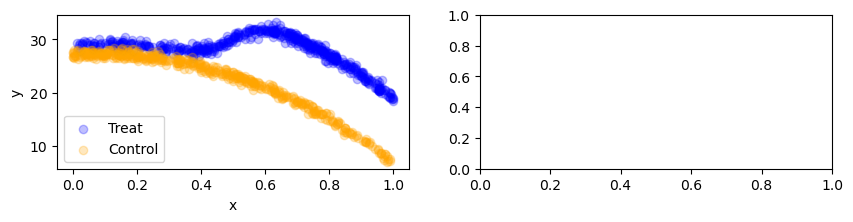

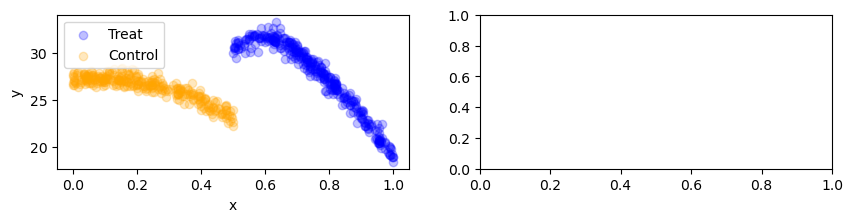

In [3]:
df = dgp_nopropensity_overlap(N=1000, 
                              hte=logit_hte, 
                              propensity_ranges = {'control':[0,0.5], 'treatment':[0.5,1]})
display( pd.crosstab(df['within_control'], df['within_treat']))
print( df['hte_gt'].mean() )
display(df['w'].mean())
df_s = df.loc[ (df['within_control']==1) | (df['within_treat']==1) ]
print( df_s['hte_gt'].mean() )
# df.describe()
display(df_s.groupby('w')['y'].mean())
for a in [df,df_s]:
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,2))
    ax[0].scatter(x=a.loc[a['w']==1]['x1'],
              y=a.loc[a['w']==1]['y'] ,
               alpha = 0.25,
               color='blue',
              label='Treat')
    ax[0].scatter(x=a.loc[a['w']==0]['x1'],
              y=a.loc[a['w']==0]['y'],
               alpha = 0.25,
               color='orange',
              label='Control')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].legend()
     

0.515

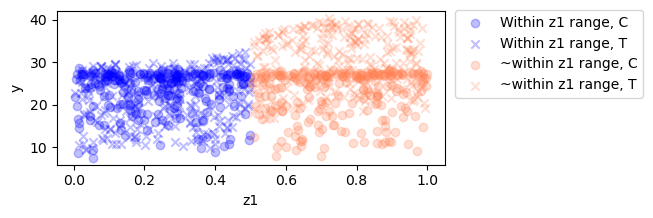

In [4]:
df = dgp_nohte_overlap(N=1000,hte=logit_hte,                  
                     hte_components=['z1'],
                     hte_components_ranges={'z1':[0,0.5], 'z2':[0.5,1]})
display(df['w'].mean())
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(5,2))
ax.scatter(x=df.loc[(df['within_control_z1']==1) & (df['w']==0) ]['z1'],
          y=df.loc[(df['within_control_z1']==1)  & (df['w']==0)]['y'] ,
           alpha = 0.25,
           color='blue',
          label='Within z1 range, C')
ax.scatter(x=df.loc[(df['within_treat_z1']==1) & (df['w']==1)]['z1'],
          y=df.loc[(df['within_treat_z1']==1)  & (df['w']==1)]['y'] ,
           alpha = 0.25,
           marker='x',
           color='blue',
          label='Within z1 range, T')

ax.scatter(x=df.loc[(df['within_control_z1']==0) & (df['w']==0) ]['z1'],
          y=df.loc[(df['within_control_z1']==0) & (df['w']==0) ]['y'] ,
           alpha = 0.25,
           color='coral',
          label='~within z1 range, C')
ax.scatter(x=df.loc[(df['within_treat_z1']==0) & (df['w']==1) ]['z1'],
          y=df.loc[(df['within_treat_z1']==0) & (df['w']==1)]['y'] ,
           alpha = 0.25,
           marker='x',
           color='coral',
          label='~within z1 range, T')

ax.set_xlabel('z1')
ax.set_ylabel('y')
ax.legend()
ax.legend(bbox_to_anchor=(1.01, 1.05))





We want to code up four different HTE models that share the same API:
1. T-Learner;
2. Doubly Robust (implicit) X-Learner;
3. OLS (as a substitute for DML); and
4. GRF.

Models 2., 3., and 4. are available in the `stnomics` package. We will manually code up model 1's `T-Learner` here.

We will code up a function that calls all the models at once, so that we can quickly iterate over these scenarios:

| # | Propensity Overlap? | HTE Dimension Overlap? |
|---|---|---|
|1 | N | N|
|2 | Y | Y|
|3 | Y | N |




In [5]:
import os as os 
from importlib import reload  # Python 3.4+

# os.chdir('C:\\Users\\tarob\\OneDrive\\Documents\\GitHub\\statanomics')
# import stnomics_test as stn
# stn = reload(stn)
import stnomics as stn

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression

In [6]:
nuisance_y = RandomForestRegressor(n_estimators=200)
nuisance_t = RandomForestClassifier(n_estimators=200)
nuisance_y_eln = ElasticNet()
nuisance_t_log = LogisticRegression()

In [7]:
def tlearner(data_est=None, 
             ymodel=None,
            outcome_name='y',
            treatment_name='w'):
    ## Modeling Training and Estimate counterfactuals
    rf_t = ymodel.fit(data_est['x1'].loc[data_est[treatment_name]==1].array.reshape(-1,1), data_est.loc[data_est[treatment_name]==1][outcome_name])
    y_1t = rf_t.predict(data_est['x1'].array.reshape(-1,1))

    rf_c = ymodel.fit(data_est['x1'].loc[data_est[treatment_name]==0].array.reshape(-1,1), data_est.loc[data_est[treatment_name]==0][outcome_name])
    y_0t = rf_c.predict(data_est['x1'].array.reshape(-1,1))

    ## Take the difference
    y_diff = y_1t - y_0t 
    return pd.DataFrame(data={'y0':y_0t, 'y1':y_1t, 'hte':y_diff})

def four_learners(data_ex=None):
    grf_output = stn.hte.trees.grf(data_est=data_ex,
                     feature_name=['x1','z1'],
                     outcome_name='y',
                     treatment_name='w',
                     het_feature='z1',
                     ymodel=nuisance_y,
                     tmodel=nuisance_t,
                     n_data_splits=4,
                     aux_dictionary={'criterion':'mse', 'honest':True, 'n_estimators':500})
    dr_output = stn.hte.other.DR(data_est=data_ex,
                     feature_name=['x1'],
                     outcome_name='y',
                     treatment_name='w',
                     het_feature='z1',
                     ymodel=nuisance_y_eln,
                     tmodel=nuisance_t_log,
                     n_data_splits=4,
                     aux_dictionary={'criterion':'mse', 'honest':True,
                                     'force_second_stage':'OLS',
                                    'lower':0.10, 'upper':0.90})
    ols_output = stn.hte.other.het_ols(data_est=data_ex,
                     feature_name=['x1'],
                     outcome_name='y',
                     treatment_name='w',
                     het_feature=['z1'],
                     ymodel=nuisance_y,
                     tmodel=nuisance_t,
                     n_data_splits=4,
                          force_second_stage='OLS')
    tlearner_output = tlearner(data_est = data_ex, ymodel=nuisance_y, outcome_name='y', treatment_name='w')
    return {'grf':grf_output[0], 'dr':dr_output[0], 'ols':ols_output[0], 'tlr':tlearner_output['hte'].values }


In [8]:
def plot_propensity(data=None):
    fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(5,2))
    ax.hist(data.loc[data['w']==1]['x1'], alpha = 0.25,
               color='blue',
              label='Treat')
    ax.hist(data.loc[data['w']==0]['x1'], alpha = 0.25,
               color='orange',
              label='Control')
    ax.set_xlabel('x')
    ax.set_ylabel('Count')
    ax.legend()
    plt.show()

def plot_z1_hte(data=None, true_data=None, figname=None):
    data['z1_rnd'] = np.round(data['z1'],2)
    data_g = data.groupby(['z1_rnd','w']).mean().reset_index()

    true_data['z1_rnd'] = np.round(true_data['z1'],2)

    true_data_g = true_data.groupby(['z1_rnd','w']).mean().reset_index()

    
    
    fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(5,4))
    ax[0].scatter(x=data_g.loc[(data_g['within_control_z1']==1) & (data_g['w']==0) ]['z1'],
              y=data_g.loc[(data_g['within_control_z1']==1)  & (data_g['w']==0)]['y'] ,
               alpha = 0.25,
               color='blue',
              label='Within z1 range, C')
    ax[0].scatter(x=data_g.loc[(data_g['within_treat_z1']==1) & (data_g['w']==1)]['z1'],
              y=data_g.loc[(data_g['within_treat_z1']==1)  & (data_g['w']==1)]['y'] ,
               alpha = 0.25,
               marker='x',
               color='blue',
              label='Within z1 range, T')

    ax[0].scatter(x=data_g.loc[(data_g['within_control_z1']==0) & (data_g['w']==0) ]['z1'],
              y=data_g.loc[(data_g['within_control_z1']==0) & (data_g['w']==0) ]['y'] ,
               alpha = 0.25,
               color='coral',
              label='~within z1 range, C')
    ax[0].scatter(x=data_g.loc[(data_g['within_treat_z1']==0) & (data_g['w']==1) ]['z1'],
              y=data_g.loc[(data_g['within_treat_z1']==0) & (data_g['w']==1)]['y'] ,
               alpha = 0.25,
               marker='x',
               color='coral',
              label='~within z1 range, T')
    ## ['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']
    ax[0].set_xlabel('z1')
    ax[0].set_ylabel('y')
    ax[0].legend()
    ax[0].legend(bbox_to_anchor=(1.01, 1.05))


    ax[1].plot(true_data_g['z1'], true_data_g['hte_gt'], 
               linewidth=10, color='grey',
               alpha=0.25, label='HTE-Ground\nTruth')
    ax[1].plot(data_g['z1'], data_g['hte_grf'], alpha=0.45, label='HTE-GRF')
    ax[1].plot(data_g['z1'], data_g['hte_dr'], alpha=0.45, label='HTE-DR')
    ax[1].plot(data_g['z1'], data_g['hte_ols'], alpha=0.45, label='HTE-OLS')
    ax[1].plot(data_g['z1'], data_g['hte_tlr'], alpha=0.45, label='HTE-TLR')
    ax[1].set_xlabel('z1')
    ax[1].set_ylabel('HTE')
    ax[1].legend()
    ax[1].legend(bbox_to_anchor=(1.01, 1.05))
    if figname is not None:
        plt.savefig(os.getcwd() + '\\Figures\\'+'{0}.png'.format(figname)
           , bbox_inches='tight')
    else:
        pass
    plt.show()

def plot_outcome(data=None):
    fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(15,2))
    ax[0].scatter(x=data.loc[data['w']==1]['x1'],
              y=data.loc[data['w']==1]['y'] ,
               alpha = 0.25,
               color='blue',
              label='Treat')
    ax[0].scatter(x=data.loc[data['w']==0]['x1'],
              y=data.loc[data['w']==0]['y'],
               alpha = 0.25,
               color='orange',
              label='Control')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].legend()
    
    ax[1].scatter(x=data.loc[data['w']==1]['z1'],
              y=data.loc[data['w']==1]['y'] ,
               alpha = 0.25,
               color='blue',
              label='Treat')
    ax[1].scatter(x=data.loc[data['w']==0]['z1'],
              y=data.loc[data['w']==0]['y'],
               alpha = 0.25,
               color='orange',
              label='Control')
    ax[1].set_xlabel('z1')
    ax[1].set_ylabel('y')
    ax[1].legend()  
    
    ax[2].scatter(x=data.loc[data['w']==1]['z1'],
              y=data.loc[data['w']==1]['hte_gt'] ,
               alpha = 0.25,
               color='blue',
              label='Treat')
    ax[2].scatter(x=data.loc[data['w']==0]['z1'],
              y=data.loc[data['w']==0]['hte_gt'],
               alpha = 0.25,
               color='orange',
              label='Control')
    ax[2].set_xlabel('z1')
    ax[2].set_ylabel('hte_gt')
    ax[2].legend()  
    
    
    plt.show()
    

#### Figures over no HTE Overlap

(336, 14) no propensity overlap


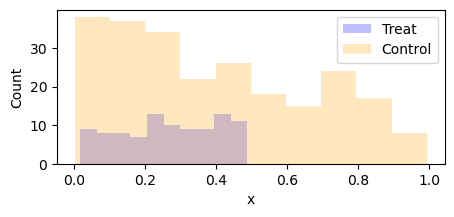

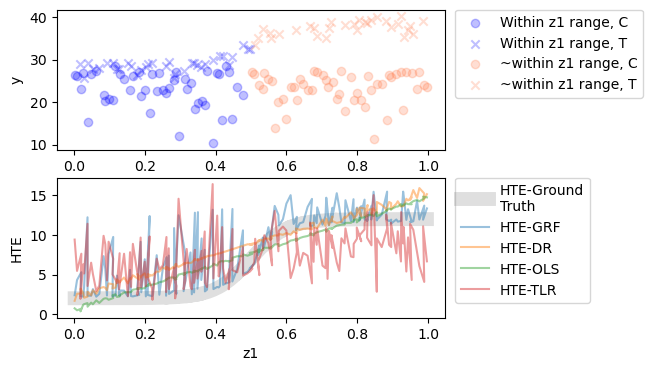

(500, 15) nothing wrong


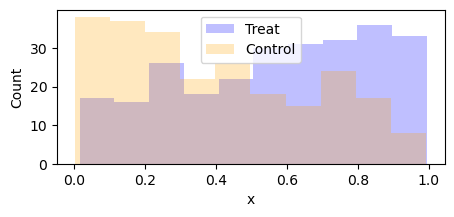

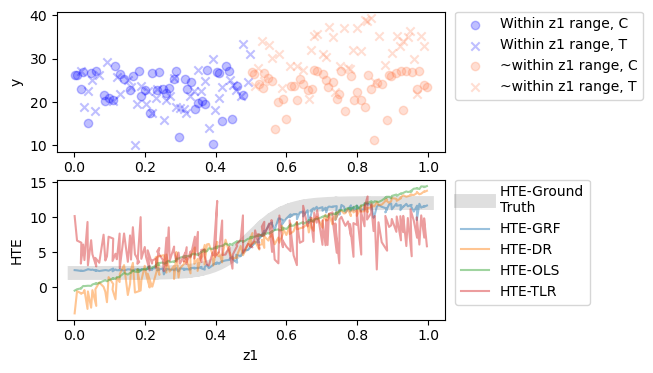

(355, 14) no z overlap


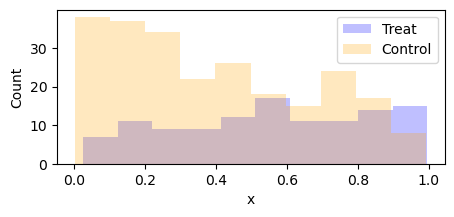

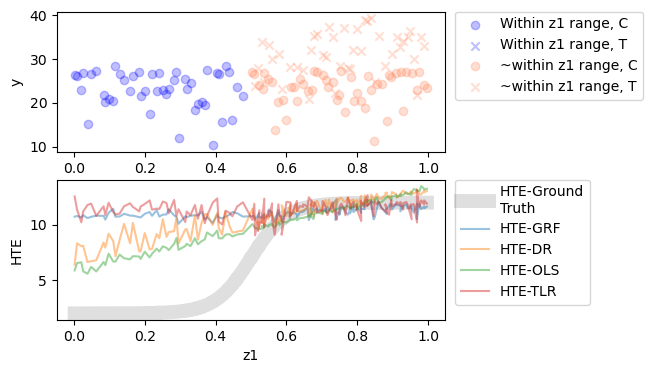

In [9]:
df = dgp_nohte_overlap(N=500,hte=logit_hte,                  
                     hte_components=['z1'],
                     hte_components_ranges={'z1':[0,0.5], 'z2':[0.5,1]},
                      propensity_ranges = {'control':[0,0.5], 'treatment':[0.5,1]})
## No propensity overlap
df0 = df.loc[df['within_treat']==0]

## No hte overlap
df2 = df.loc[df['within_treat_z1']==0]


for d,name in zip([df0,df,df2],['no propensity overlap','nothing wrong','no z overlap']):
    print(d.shape, name)
    
    m_output = four_learners(d)
    d['hte_grf'] = m_output['grf']
    d['hte_dr'] = m_output['dr']
    d['hte_ols'] = m_output['ols']
    d['hte_tlr'] = m_output['tlr']

    plot_propensity(data=d)
    plot_z1_hte(data=d,true_data=df)
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].describe() )
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].corr()['hte_gt'] )

#### Figures over different HTE Functions

logit


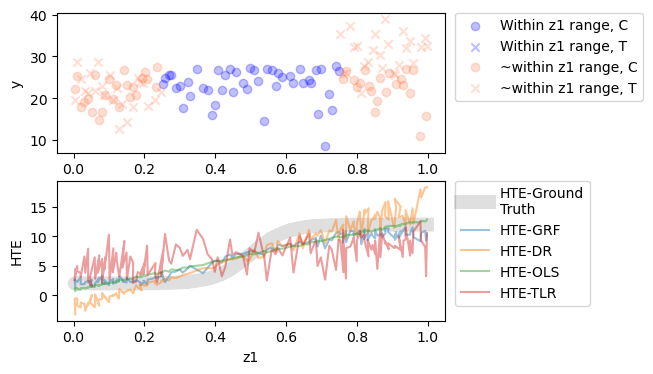

single


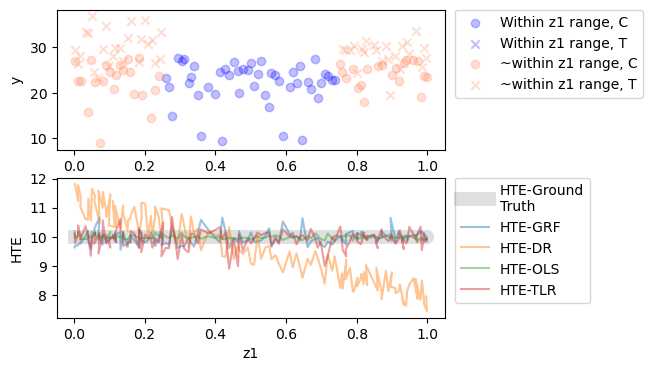

linear


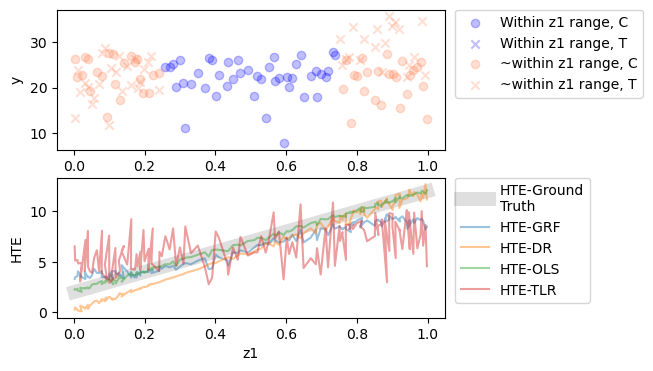

squared


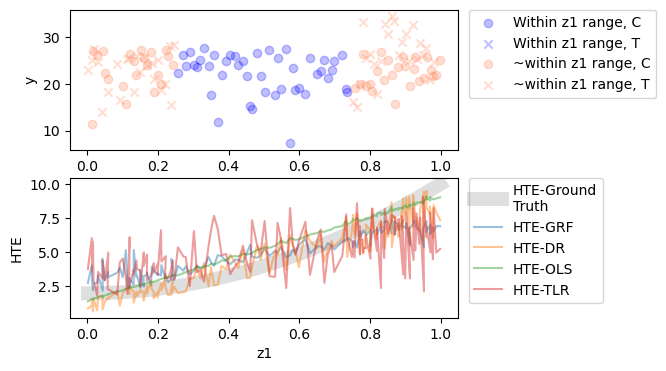

polynomial


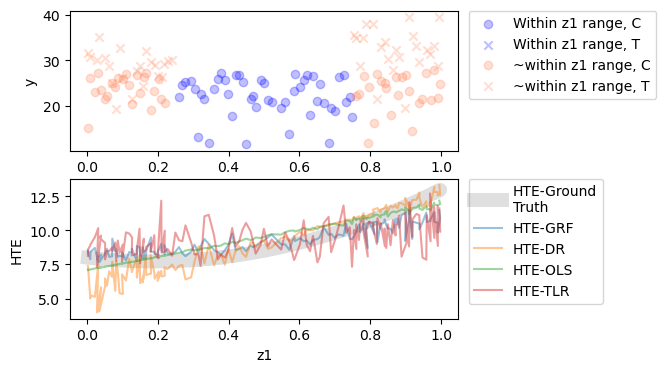

friedman


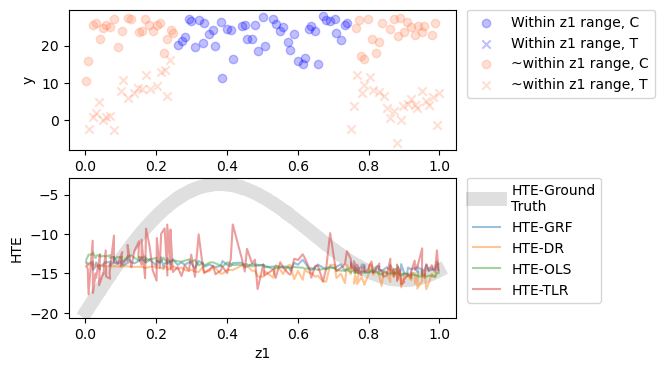

In [10]:
for hte_type,func in zip(
    ['logit','single','linear','squared','polynomial','friedman'],
    [logit_hte,
        single_hte,
        linear_hte,
        squared_hte,
        polynomial_hte,
        friedman_hte]):
    df = dgp_nohte_overlap(N=500,hte=func,                  
                         hte_components=['z1'],
                         hte_components_ranges={'z1':[0.25,0.75], 'z2':[0.5,1]},
                          propensity_ranges = {'control':[0,0.5], 'treatment':[0.5,1]})
    print(hte_type)
#     plot_outcome(data=df)
    df2 = df.loc[df['within_treat_z1']==0]

    m_output = four_learners(df2)
    df2['hte_grf'] = m_output['grf']
    df2['hte_dr'] = m_output['dr']
    df2['hte_ols'] = m_output['ols']
    df2['hte_tlr'] = m_output['tlr']

#     plot_propensity(data=df2)
    plot_z1_hte(data=df2,true_data=df, figname='HTE_Figure_10x_{0}'.format(hte_type))
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].describe() )
    # print( df[['hte_grf','hte_dr','hte_ols','hte_tlr','hte_gt']].corr()['hte_gt'] )